In [1]:
import pandas as pd
import numpy as np
import scipy as sc
from scipy.spatial import distance
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier 
import seaborn as sns

In [2]:
## read all climate-soil parameters 
all_data = pd.read_csv("full_dataframes/result_k_20_climate_soil.csv")

q_names = ["V1","V2","V3","V4","V5","V6","V7","V8","V9","V10","V11","V12","V13","V14","V15","V16","V17","V18","V19","V20"]
Q = all_data[q_names]
features =  ['bio1', 'bio2', 'bio3',
       'bio4', 'bio5', 'bio6', 'bio7', 'bio8', 'bio9', 'bio10', 'bio11',
       'bio12', 'bio13', 'bio14', 'bio15', 'bio16', 'bio17', 'bio18', 'bio19',
       'solar_min', 'solar_max', 'solar_mean', 'wind_min', 'wind_max',
       'wind_mean', 'vapr_min', 'vapr_max', 'vapr_mean', 'T_GRAVEL', 'T_SAND',
       'T_SILT', 'T_CLAY', 'T_REF_BULK_DENSITY', 'T_OC', 'T_PH_H2O',
       'T_CEC_CLAY', 'T_CEC_SOIL', 'T_BS', 'T_TEB', 'T_CACO3', 'T_CASO4',
       'T_ESP', 'T_ECE', 'S_GRAVEL', 'S_SAND', 'S_SILT', 'S_CLAY',
       'S_REF_BULK_DENSITY', 'S_OC', 'S_PH_H2O', 'S_CEC_CLAY', 'S_CEC_SOIL',
       'S_BS', 'S_TEB', 'S_CACO3', 'S_CASO4', 'S_ESP', 'S_ECE']

df = all_data[features]

In [9]:
def make_label(v):
    tmp = np.argmax(v)
    return tmp if v[tmp] > 0.70 else -1

label_simple = np.apply_along_axis(make_label, 1, Q)

In [10]:
new_Q = Q.iloc[label_simple != -1]
label = label_simple[label_simple != -1]
data = all_data.iloc[label_simple != -1]
coordinate = data[['longitude', 'latitude']]
df = data[features]
print(len(new_Q), len(Q))

771 1048


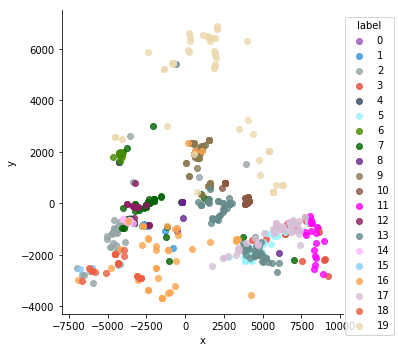

In [164]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_res = pca.fit_transform(np.array(df))
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", 
          "#98f5ff", "#458b00", "#006400", "#68228b", "#8b7a50", "#8b5742",
         "#ff00ff","#8b1c62", "#668b8b","#ffbbff","#87ceff", "#ffa54f","#d8bfd8","#ee5c42","#eed8ae","#eeee00"]

df_pca = pd.DataFrame({'x': pca_res[:,0], 'y': pca_res[:,1],'label': label})
facet = sns.lmplot(data=df_pca, x='x', y='y', hue='label', 
                   fit_reg=False, legend=True, legend_out=True,  palette=sns.color_palette(flatui))

In [144]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
seed = 1009
test_size = 0.2
coor_label = all_data[['longitude', 'latitude']]
X_train, X_test, y_train, y_test = train_test_split(df, label, test_size=test_size, random_state=seed)

In [145]:
# fit model no training data
model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
predictions = np.round(y_pred)

R2_score: 0.688300491146
accuracy: 0.864516129032
             precision    recall  f1-score   support

          0       1.00      0.75      0.86         4
          1       1.00      0.94      0.97        16
          2       0.62      0.71      0.67         7
          3       0.00      0.00      0.00         3
          4       1.00      1.00      1.00         5
          5       1.00      1.00      1.00         6
          6       1.00      1.00      1.00         9
          7       0.79      0.92      0.85        12
          8       1.00      0.89      0.94         9
          9       1.00      1.00      1.00        14
         10       1.00      1.00      1.00         8
         11       0.33      0.33      0.33         3
         12       1.00      1.00      1.00         4
         13       0.88      0.88      0.88         8
         14       0.86      1.00      0.92         6
         15       0.00      0.00      0.00         0
         16       0.75      0.55      0.63      

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


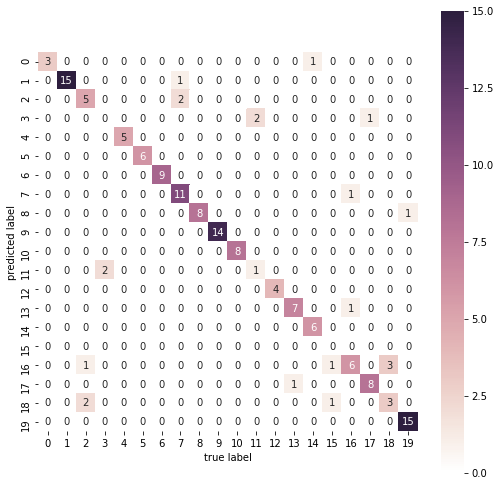

In [146]:
from sklearn.metrics import confusion_matrix
print("R2_score:", metrics.r2_score(y_test,y_pred))
accuracy = accuracy_score(y_test, y_pred)
print("accuracy:", accuracy)
print(metrics.classification_report(y_pred, y_test))
mat_knn = confusion_matrix(y_test, y_pred)
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, sub = plt.subplots(1, 1)
fig.set_size_inches(8.5, 8.5)
sns.heatmap(mat_knn.T, square=True, cmap=cmap, annot=True, fmt='d')
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.show()

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 771 samples in 0.001s...
[t-SNE] Computed neighbors for 771 samples in 0.040s...
[t-SNE] Computed conditional probabilities for sample 771 / 771
[t-SNE] Mean sigma: 31.706095
[t-SNE] KL divergence after 250 iterations with early exaggeration: 46.072529
[t-SNE] Error after 300 iterations: 0.233006


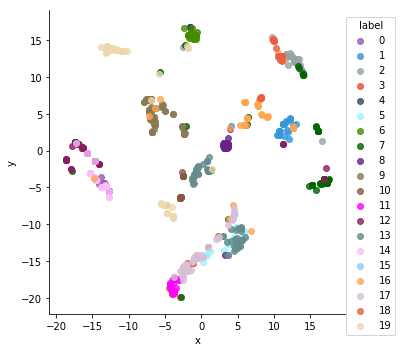

In [167]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(np.array(df))
df_tsne =  pd.DataFrame({'x': tsne_results[:,0], 'y': tsne_results[:,1] ,'label': label})
facet = sns.lmplot(data=df_tsne, x='x', y='y', hue='label', 
                   fit_reg=False, legend=True, legend_out=True,  palette=sns.color_palette(flatui))

In [152]:
print(pd.Series(model.feature_importances_, index=X_train.columns))
df_feature = pd.DataFrame({'name':X_train.columns , 'impotance': model.feature_importances_ })
index =  np.argsort(np.abs(lasso.coef_[np.abs(lasso.coef_) != 0]))[::-1]
X_train.columns[index]

bio1                  0.016250
bio2                  0.038594
bio3                  0.019687
bio4                  0.053906
bio5                  0.011875
bio6                  0.009219
bio7                  0.045156
bio8                  0.024062
bio9                  0.024375
bio10                 0.015313
bio11                 0.017344
bio12                 0.024688
bio13                 0.013594
bio14                 0.013750
bio15                 0.016406
bio16                 0.017969
bio17                 0.020781
bio18                 0.059844
bio19                 0.020781
solar_min             0.061875
solar_max             0.059062
solar_mean            0.035781
wind_min              0.025937
wind_max              0.035312
wind_mean             0.008906
vapr_min              0.032812
vapr_max              0.030781
vapr_mean             0.012187
T_GRAVEL              0.022031
T_SAND                0.010000
T_SILT                0.003906
T_CLAY                0.003750
T_REF_BU

Index(['wind_min', 'T_ECE', 'vapr_min', 'solar_max', 'solar_mean', 'bio19',
       'solar_min', 'vapr_mean', 'T_BS', 'T_CLAY', 'vapr_max', 'bio3',
       'T_CEC_SOIL', 'wind_mean', 'T_CEC_CLAY', 'bio2', 'S_SAND', 'bio1',
       'T_SILT', 'bio11', 'bio5', 'bio6', 'T_OC', 'T_ESP', 'T_CASO4',
       'T_CACO3', 'T_SAND', 'T_GRAVEL', 'bio12', 'bio10', 'wind_max', 'bio7',
       'bio14', 'T_REF_BULK_DENSITY', 'bio13', 'bio15', 'T_TEB', 'T_PH_H2O',
       'bio9', 'bio16', 'bio18', 'S_GRAVEL', 'bio4', 'bio17', 'bio8'],
      dtype='object')

In [163]:
arr = np.array(df_feature)
inx = np.argsort(arr[:, 0])[-20:]
new_arr = arr[inx]
for i in range(len(new_arr) + 1):
    print("{:<10}".format(new_arr[-i, 1]))

bio16     
solar_min 
bio18     
solar_max 
bio4      
bio7      
bio2      
solar_mean
wind_max  
vapr_min  
vapr_max  
wind_min  
T_CEC_CLAY
bio12     
bio9      
bio8      
T_GRAVEL  
bio19     
bio17     
bio3      
bio16     


array([[0.016249999403953552, 'bio1'],
       [0.038593750447034836, 'bio2'],
       [0.019687499850988388, 'bio3'],
       [0.05390625074505806, 'bio4'],
       [0.011874999850988388, 'bio5'],
       [0.009218749590218067, 'bio6'],
       [0.04515625163912773, 'bio7'],
       [0.024062499403953552, 'bio8'],
       [0.02437499910593033, 'bio9'],
       [0.015312500298023224, 'bio10'],
       [0.017343750223517418, 'bio11'],
       [0.024687500670552254, 'bio12'],
       [0.013593750074505806, 'bio13'],
       [0.013749999925494194, 'bio14'],
       [0.01640624925494194, 'bio15'],
       [0.01796874962747097, 'bio16'],
       [0.020781250670552254, 'bio17'],
       [0.059843748807907104, 'bio18'],
       [0.020781250670552254, 'bio19'],
       [0.06187500059604645, 'solar_min'],
       [0.059062499552965164, 'solar_max'],
       [0.03578124940395355, 'solar_mean'],
       [0.025937499478459358, 'wind_min'],
       [0.03531249985098839, 'wind_max'],
       [0.008906249888241291, 'wind_me

Это то что осталось после корреляции
"bio4"       "bio8"       "bio13"      "bio15"      "bio18"      "wind_mean"  "vapr_mean" 
"T_GRAVEL"   "T_SAND"     "T_OC"       "T_ESP"      "S_CEC_CLAY" "S_BS"

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Computing regularization path using the elastic net...


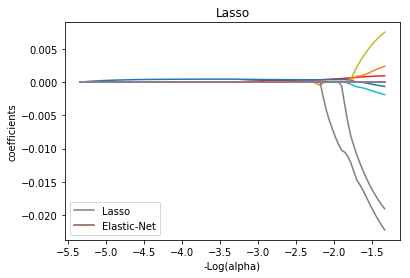

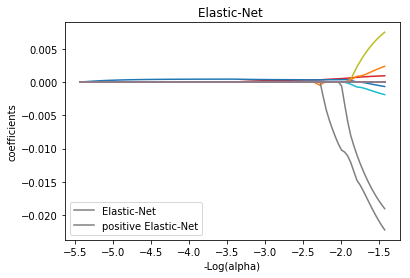

In [97]:
from itertools import cycle

from sklearn.linear_model import lasso_path, enet_path
from sklearn import datasets

diabetes = datasets.load_diabetes()
X =  X_train
y = y_train

# Compute paths

eps = 1e-4  # the smaller it is the longer is the path

alphas_lasso, coefs_lasso, _ = lasso_path(X, y, eps, fit_intercept=False)

print("Computing regularization path using the elastic net...")
alphas_enet, coefs_enet, _ = enet_path(
    X, y, eps=eps, l1_ratio=0.8, fit_intercept=False)


# Display results

plt.figure(1)
ax = plt.gca()

colors = cycle(['b', 'r', 'g', 'c', 'k'])
neg_log_alphas_lasso = -np.log10(alphas_lasso)
neg_log_alphas_enet = -np.log10(alphas_enet)
for coef_l in coefs_lasso:
    l1 = plt.plot(neg_log_alphas_lasso, coef_l)

    

plt.xlabel('-Log(alpha)')
plt.ylabel('coefficients')
plt.title('Lasso')
plt.legend((l1[-1], l2[-1]), ('Lasso', 'Elastic-Net'), loc='lower left')
plt.axis('tight')
plt.show()
for coef_e in coefs_enet:
    l2 = plt.plot(neg_log_alphas_enet, coef_e)



plt.xlabel('-Log(alpha)')
plt.ylabel('coefficients')
plt.title('Elastic-Net ')
plt.legend((l1[-1], l2[-1]), ('Elastic-Net', 'positive Elastic-Net'),
           loc='lower left')
plt.axis('tight')
plt.show()

In [91]:
from sklearn import linear_model

lassocv = linear_model.LassoCV(alphas=None, cv=10, max_iter=100000, normalize=True)
lassocv.fit(X_train, y_train)
lasso = linear_model.Lasso(max_iter=10000, normalize=True)
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, y_train)
print(pd.Series(lasso.coef_, index=X_train.columns))

index =  np.argsort(np.abs(lasso.coef_[np.abs(lasso.coef_) != 0]))[::-1]
X_train.columns[index]

bio1                   0.239238
bio2                  -0.511813
bio3                   1.079484
bio4                  -0.002014
bio5                   0.000000
bio6                  -0.144516
bio7                   0.141790
bio8                  -0.038639
bio9                  -0.000041
bio10                  0.000000
bio11                  0.000000
bio12                 -0.004680
bio13                  0.000000
bio14                  0.057094
bio15                 -0.190546
bio16                  0.057970
bio17                 -0.030480
bio18                 -0.037599
bio19                 -0.025496
solar_min             -0.002727
solar_max             -0.000193
solar_mean             0.002206
wind_min              -4.841542
wind_max               3.688894
wind_mean              0.000000
vapr_min              12.765020
vapr_max               6.417360
vapr_mean            -25.802669
T_GRAVEL              -0.043220
T_SAND                 0.000000
T_SILT                -0.742638
T_CLAY  

Index(['wind_min', 'T_ECE', 'vapr_min', 'solar_max', 'solar_mean', 'bio19',
       'solar_min', 'vapr_mean', 'T_BS', 'T_CLAY', 'vapr_max', 'bio3',
       'T_CEC_SOIL', 'wind_mean', 'T_CEC_CLAY', 'bio2', 'S_SAND', 'bio1',
       'T_SILT', 'bio11', 'bio5', 'bio6', 'T_OC', 'T_ESP', 'T_CASO4',
       'T_CACO3', 'T_SAND', 'T_GRAVEL', 'bio12', 'bio10', 'wind_max', 'bio7',
       'bio14', 'T_REF_BULK_DENSITY', 'bio13', 'bio15', 'T_TEB', 'T_PH_H2O',
       'bio9', 'bio16', 'bio18', 'S_GRAVEL', 'bio4', 'bio17', 'bio8'],
      dtype='object')

In [ ]:
"bio2"       "bio3"       "bio4"       "bio8"       "bio10"      "bio13"      "bio15"     
 [8] "bio18"      "solar_max"  "wind_mean"  "vapr_mean"  "T_GRAVEL"   "T_SAND"     "T_CEC_SOIL"
[15] "T_CACO3"    "S_GRAVEL"   "S_CEC_CLAY" "S_BS"       "S_CASO4"    "S_ESP"

In [115]:
# df2 = df[["bio4" ,"bio8" ,"bio13" , "bio15", "bio18" , "wind_mean" , "vapr_mean" , "T_GRAVEL" , 
#                "T_SAND", "T_OC", "T_ESP", "S_CEC_CLAY", "S_BS"]]
 

df2 = df[[ 'bio2', 'bio3',
       'bio4', 'bio8',  'bio10', 'bio13', 'bio15', 'bio18', 'solar_max',
       'wind_mean', 'vapr_mean', 'T_GRAVEL', 'T_SAND',
       'T_CEC_SOIL',  'T_CACO3', 'S_GRAVEL',  'S_CEC_CLAY', 
       'S_BS', 'S_CASO4', 'S_ESP']]

In [116]:
X_train, X_test, y_train, y_test = train_test_split(df2, label, test_size=test_size, random_state=seed)

In [119]:
model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
predictions = np.round(y_pred)

R2_score: 0.53674051949
accuracy: 0.811764705882
             precision    recall  f1-score   support

          0       0.57      1.00      0.73         4
          1       1.00      0.87      0.93        23
          2       0.42      0.71      0.53         7
          3       0.40      0.50      0.44         4
          4       1.00      0.75      0.86         4
          5       0.83      0.71      0.77         7
          6       0.93      1.00      0.97        14
          7       0.73      0.79      0.76        28
          8       1.00      1.00      1.00        13
          9       0.97      0.85      0.91        34
         10       0.89      1.00      0.94         8
         11       0.83      0.71      0.77         7
         12       0.56      0.71      0.63         7
         13       0.88      0.83      0.86        18
         14       0.91      0.67      0.77        15
         15       0.00      0.00      0.00         3
         16       0.20      0.50      0.29       

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


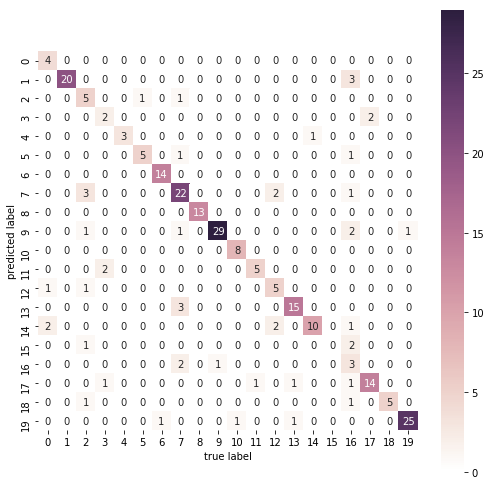

In [120]:
from sklearn.metrics import confusion_matrix
print("R2_score:", metrics.r2_score(y_test,y_pred))
accuracy = accuracy_score(y_test, y_pred)
print("accuracy:", accuracy)
print(metrics.classification_report(y_pred, y_test))
mat_knn = confusion_matrix(y_test, y_pred)
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, sub = plt.subplots(1, 1)
fig.set_size_inches(8.5, 8.5)
sns.heatmap(mat_knn.T, square=True, cmap=cmap, annot=True, fmt='d')
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.show()